In [1]:
op='ycsb_c_init'

In [2]:
import pandas as pd

df = pd.read_csv('../01_preprocess/ps/'+op+'_new_ps.csv')


In [3]:
# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(['object']).columns

print("Number of columns:", df.shape[1])

# Apply one-hot encoding to non-numeric columns
df = pd.get_dummies(df, columns=non_numeric_columns)

print("Number of columns after one-hot:", df.shape[1])

Number of columns: 27
Number of columns after one-hot: 27


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Split the dataframe into features (X) and target (y)
X = df.drop('time', axis=1)
y = df['time']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Create a random forest regressor
reg = LinearRegression()

# Fit the regressor to the training data
reg.fit(X_train, y_train)

# Predict the percentile brackets for the test data
y_pred = reg.predict(X_test)

# Evaluate the performance of the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("MSE:",mse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)



MSE: 4.895218037362974e-16
R-squared: 0.9342027632328983


In [5]:
X_train.columns

Index(['const_basicHintCount', 'const_enableBasicHead', 'const_enableDense',
       'const_enableDense2', 'const_enableDensifySplit', 'const_enableHash',
       'const_enableHashAdapt', 'const_enableHeadNode', 'const_enablePrefix',
       'const_hashSimdWidth', 'const_hashSortUseStdMerge',
       'const_hashUseCrc32', 'const_hashUseSimd', 'const_headNode4HintCount',
       'const_headNode8HintCount', 'const_pageSizeInner', 'const_pageSizeLeaf',
       'data_size', 'data_sorted', 'density', 'payload_size', 'rand_seed',
       'ycsb_range_len', 'ycsb_zipf', 'config_name_hints',
       'data_name_data/urls'],
      dtype='object')

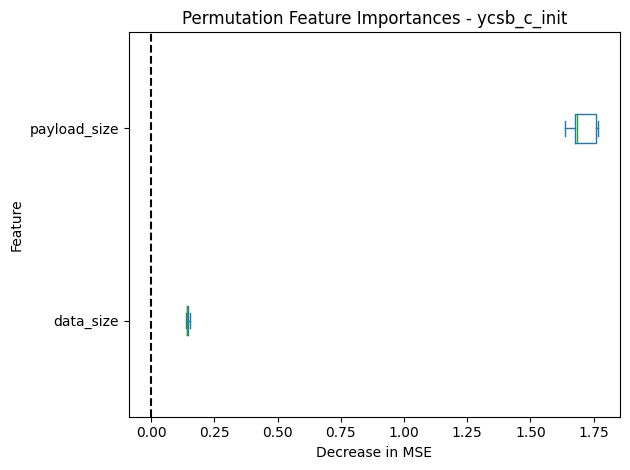

In [6]:
from sklearn.inspection import permutation_importance

# Calculate the feature importances
result = permutation_importance(reg, X_test, y_test, n_repeats=10, random_state=42, scoring='r2')

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
#get the top 5 importances
importances_filtered = importances.loc[:, importances.mean() > 0.001]

ax = importances_filtered.plot.box(vert=False, whis=10)
ax.set_title("Permutation Feature Importances - "+op)
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in MSE")
ax.set_ylabel("Feature")
ax.figure.tight_layout()

In [7]:
import shap
explainer = shap.Explainer(reg)
shap_values = explainer.shap_values(X_test)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: LinearRegression()

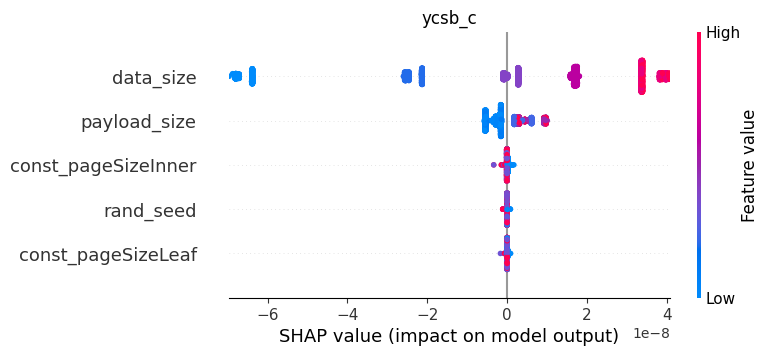

In [37]:
import matplotlib.pyplot as plt
features=X.columns
shap.summary_plot(shap_values,X_test,feature_names=features, max_display=5, show=False)
ax = plt.gca()

#get minimum and maximum shap_value
shap_min, shap_max = shap_values.min(), shap_values.max()
# You can change the min and max value of xaxis by changing the arguments of:
ax.set_xlim(shap_min, shap_max) 
plt.title(op)
plt.show()

In [38]:
#create records that vary data_size, payload_size, and const_pageSizeLeaf
to_predict=pd.DataFrame(columns=X.columns)
X.columns


Index(['const_basicHintCount', 'const_enableBasicHead', 'const_enableDense',
       'const_enableDense2', 'const_enableDensifySplit', 'const_enableHash',
       'const_enableHashAdapt', 'const_enableHeadNode', 'const_enablePrefix',
       'const_hashSimdWidth', 'const_hashSortUseStdMerge',
       'const_hashUseCrc32', 'const_hashUseSimd', 'const_headNode4HintCount',
       'const_headNode8HintCount', 'const_pageSizeInner', 'const_pageSizeLeaf',
       'data_size', 'data_sorted', 'density', 'payload_size', 'rand_seed',
       'ycsb_range_len', 'ycsb_zipf', 'config_name_hints',
       'data_name_data/urls'],
      dtype='object')

In [100]:
import pandas as pd
from random import randrange

# Define the values to vary
data_sizes = [1000000, 2000000, 3000000, 4000000, 5000000, 6000000]
payload_sizes = [4, 8, 16, 32, 64, 128, 256]
psl_exps = [2 ** e for e in range(11, 14)]  # Generate 10 random values

# Generate all combinations of the varying values
rows = []
for data_size in data_sizes:
    for payload_size in payload_sizes:
        for psl in psl_exps:
            row = {
                'const_basicHintCount': 16.0,
                'const_enableBasicHead': 1.0,
                'const_enableDense': 0.0,
                'const_enableDense2': 0.0,
                'const_enableDensifySplit': 0.0,
                'const_enableHash': 0.0,
                'const_enableHashAdapt': 0.0,
                'const_enableHeadNode': 0.0,
                'const_enablePrefix': 1.0,
                'const_hashSimdWidth': 32.0,
                'const_hashSortUseStdMerge': 1.0,
                'const_hashUseCrc32': 0.0,
                'const_hashUseSimd': 1.0,
                'const_headNode4HintCount': 16.0,
                'const_headNode8HintCount': 16.0,
                'const_pageSizeInner': 8192.0,
                'const_pageSizeLeaf': psl,
                'data_size': data_size,
                'data_sorted': 0.0,
                'density': 1.0,
                 'payload_size': payload_size,
                'rand_seed': 1707663300,
                'ycsb_range_len': 100.0,
                'ycsb_zipf': 1.0,
                'config_name_hints': True,
                'data_name_data/urls': True,
            }
            rows.append(row)

# Create a DataFrame from the rows
df_predicted = pd.DataFrame(rows)
df_predicted

,const_basicHintCount,const_enableBasicHead,const_enableDense,const_enableDense2,const_enableDensifySplit,const_enableHash,const_enableHashAdapt,const_enableHeadNode,const_enablePrefix,const_hashSimdWidth,...,const_pageSizeLeaf,data_size,data_sorted,density,payload_size,rand_seed,ycsb_range_len,ycsb_zipf,config_name_hints,data_name_data/urls
0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,...,2048,1000000,0.0,1.0,4,1707663300,100.0,1.0,True,True
1,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,...,4096,1000000,0.0,1.0,4,1707663300,100.0,1.0,True,True
2,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,...,8192,1000000,0.0,1.0,4,1707663300,100.0,1.0,True,True
3,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,...,2048,1000000,0.0,1.0,8,1707663300,100.0,1.0,True,True
4,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,...,4096,1000000,0.0,1.0,8,1707663300,100.0,1.0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,...,4096,6000000,0.0,1.0,128,1707663300,100.0,1.0,True,True
122,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,...,8192,6000000,0.0,1.0,128,1707663300,100.0,1.0,True,True
123,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,...,2048,6000000,0.0,1.0,256,1707663300,100.0,1.0,True,True
124,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,...,4096,6000000,0.0,1.0,256,1707663300,100.0,1.0,True,True


In [101]:
df_predicted['time'] = reg.predict(df_predicted)
df_predicted

,const_basicHintCount,const_enableBasicHead,const_enableDense,const_enableDense2,const_enableDensifySplit,const_enableHash,const_enableHashAdapt,const_enableHeadNode,const_enablePrefix,const_hashSimdWidth,...,data_size,data_sorted,density,payload_size,rand_seed,ycsb_range_len,ycsb_zipf,config_name_hints,data_name_data/urls,time
0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,...,1000000,0.0,1.0,4,1707663300,100.0,1.0,True,True,4.469633e-07
1,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,...,1000000,0.0,1.0,4,1707663300,100.0,1.0,True,True,4.480435e-07
2,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,...,1000000,0.0,1.0,4,1707663300,100.0,1.0,True,True,4.502041e-07
3,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,...,1000000,0.0,1.0,8,1707663300,100.0,1.0,True,True,4.511203e-07
4,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,...,1000000,0.0,1.0,8,1707663300,100.0,1.0,True,True,4.522006e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,...,6000000,0.0,1.0,128,1707663300,100.0,1.0,True,True,6.445596e-07
122,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,...,6000000,0.0,1.0,128,1707663300,100.0,1.0,True,True,6.467201e-07
123,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,...,6000000,0.0,1.0,256,1707663300,100.0,1.0,True,True,7.765048e-07
124,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,...,6000000,0.0,1.0,256,1707663300,100.0,1.0,True,True,7.775851e-07


In [8]:
df_relevant = df_predicted[['data_size', 'payload_size', 'const_pageSizeLeaf', 'time']]
# Group by data_size and payload_size and find the minimum time
min_times_model = df_relevant.groupby(['data_size', 'payload_size'])['time'].min().reset_index()

# Merge with df_relevant to get the corresponding const_pageSizeLeaf
min_times_model = min_times_model.merge(df_relevant, on=['data_size', 'payload_size', 'time'])

# Print the result
min_times_model[['data_size', 'payload_size', 'const_pageSizeLeaf', 'time']]


NameError: name 'df_predicted' is not defined

In [103]:
concatenated_values = min_times_model.groupby(['data_size', 'payload_size'])['const_pageSizeLeaf'].agg(lambda x: ', '.join(map(str, x))).reset_index()
concatenated_values


,data_size,payload_size,const_pageSizeLeaf
0,1000000,4,2048
1,1000000,8,2048
2,1000000,16,2048
3,1000000,32,2048
4,1000000,64,2048
5,1000000,128,2048
6,1000000,256,2048
7,2000000,4,2048
8,2000000,8,2048
9,2000000,16,2048


In [ ]:
row = {
    'data_size': data_size,
    'payload_size': payload_size,
    'const_pageSizeLeaf': psl,
    'const_basicHintCount': 16.0,
    'const_enableBasicHead': 1.0,
    'const_enableDense': 0.0,
    'const_enableDense2': 0.0,
    'const_enableDensifySplit': 0.0,
    'const_enableHash': 0.0,
    'const_enableHashAdapt': 0.0,
    'const_enableHeadNode': 0.0,
    'const_enablePrefix': 1.0,
    'const_hashSimdWidth': 32.0,
    'const_hashSortUseStdMerge': 1.0,
    'const_hashUseCrc32': 0.0,
    'const_hashUseSimd': 1.0,
    'const_headNode4HintCount': 16.0,
    'const_headNode8HintCount': 16.0,
    'const_pageSizeInner': 8192.0,
    'data_sorted': 0.0,
    'density': 1.0,
    'rand_seed': 1707663300,
    'ycsb_range_len': 100.0,
    'ycsb_zipf': 1.0,
    'config_name_hints': True,
    'data_name_data/urls': True,
}

In [14]:
most_occuring_values = X.mode().iloc[0]
most_occuring_values

const_basicHintCount               16.0
const_enableBasicHead               1.0
const_enableDense                   0.0
const_enableDense2                  0.0
const_enableDensifySplit            0.0
const_enableHash                    0.0
const_enableHashAdapt               0.0
const_enableHeadNode                0.0
const_enablePrefix                  1.0
const_hashSimdWidth                32.0
const_hashSortUseStdMerge           1.0
const_hashUseCrc32                  0.0
const_hashUseSimd                   1.0
const_headNode4HintCount           16.0
const_headNode8HintCount           16.0
const_pageSizeInner              8192.0
const_pageSizeLeaf               4096.0
data_size                     1000000.0
data_sorted                         0.0
density                             1.0
payload_size                       16.0
rand_seed                    1707663300
ycsb_range_len                    100.0
ycsb_zipf                           1.0
config_name_hints                  True


In [4]:
op

'ycsb_c_init'

In [5]:
df2_relevant = df[['data_size', 'payload_size', 'const_pageSizeLeaf', 'time']]
# Group by data_size and payload_size and find the mean time
min_times1 = df2_relevant.groupby(['data_size', 'payload_size', 'const_pageSizeLeaf'])['time'].mean().reset_index()

min_times = min_times1.groupby(['data_size', 'payload_size'])['time'].min().reset_index()


# Merge with df_relevant to get the corresponding const_pageSizeLeaf
min_times = min_times.merge(min_times1, on=['data_size', 'payload_size', 'time'])

# Print the result
min_times[['data_size', 'payload_size', 'const_pageSizeLeaf', 'time']]


,data_size,payload_size,const_pageSizeLeaf,time
0,1000000,4,4096,4.041818e-07
1,1000000,8,4096,4.119600e-07
2,1000000,16,4096,4.263957e-07
3,1000000,32,8192,4.518468e-07
4,1000000,64,8192,4.915798e-07
5,1000000,128,8192,5.583909e-07
6,1000000,256,8192,6.728545e-07
7,2000000,4,2048,4.521694e-07
8,2000000,8,4096,4.622828e-07
9,2000000,16,4096,4.758623e-07


In [21]:
2.259901e-07 / 2.302056e-07

0.9816881083692143

In [19]:
aa= min_times[['data_size', 'payload_size', 'const_pageSizeLeaf', 'time']]
aa = aa.sort_values(by=['data_size', 'payload_size'])
aa

,data_size,payload_size,const_pageSizeLeaf,time
0,1000000,4,4096,2.259901e-07
1,1000000,8,4096,2.302056e-07
2,1000000,16,8192,2.373162e-07
3,1000000,32,8192,2.458333e-07
4,1000000,64,8192,2.553345e-07
5,1000000,128,2048,2.569774e-07
6,1000000,256,4096,2.572654e-07
7,2000000,4,8192,2.744222e-07
8,2000000,8,8192,2.789869e-07
9,2000000,16,8192,2.832741e-07


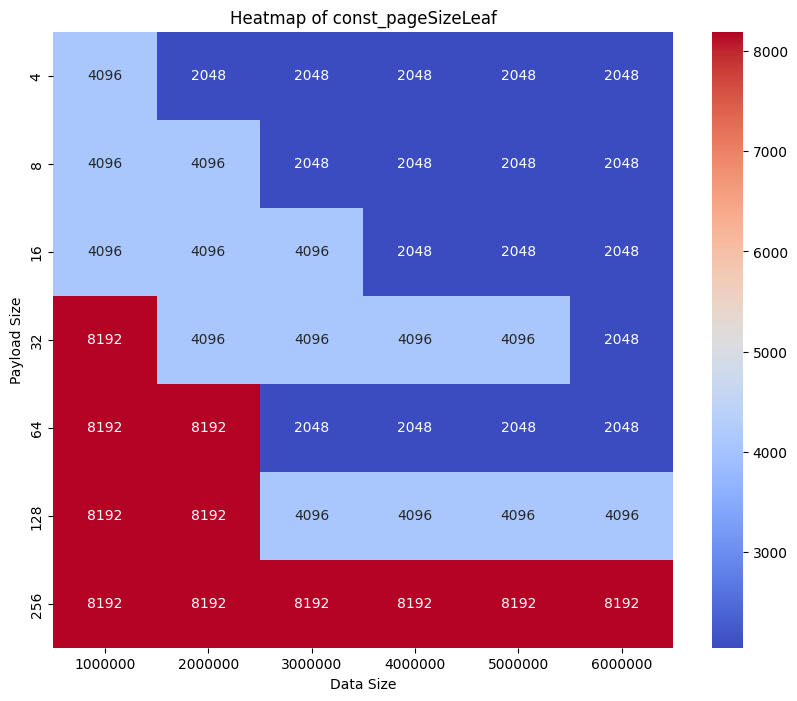

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape the data using pivot_table
heatmap_data = min_times.pivot_table(index='payload_size', columns='data_size', values='const_pageSizeLeaf')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".0f", cbar=True)
plt.xlabel('Data Size')
plt.ylabel('Payload Size')
plt.title('Heatmap of const_pageSizeLeaf')
plt.show()
